Возьмем для выполнения работы датасет с Kaggle от компании-телекома.

**Задача**: исследование датасета и построение модели машинного обучения для предсказания пользователей, готовых разорвать контракт на обслуживание. Модель ML должна предсказывать бинарный признак 1 \ 0 для пользователей тестового датасета. Целевой признак - `churn`

**Метрика**: телеком-оператор будет пытаться удержать потенциально готовых расторгнуть контракт пользователей. Например, предлагаю скидки или иные выгодные предложения. Таким образом, в качестве метрики измерения качества нам не подойдет только precision или recall. Ведь мы не хотим раздавать акционные предложения пользователям, которые и так готовы были работать с оператором, но и боимся потерять каждого недовольного. ROC-AUC лучше подходит для оценки моделей, когда важно минимизировать ошибки между классами, особенно в случае несбалансированных данных (датасет не сбалансированн, мы увидим это далее)

# Исследование

## Импорт:

In [ ]:
!pip install phik
!pip install catboost
!pip install optuna
!pip install lime

import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from lime.lime_tabular import LimeTabularExplainer
import shap
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer

import optuna
import phik
from sklearn.manifold import TSNE
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, cv, Pool
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Загрузка и обзор данных

In [ ]:
!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv

Downloading...
From: https://drive.google.com/uc?id=1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K
To: /content/train.csv
100% 664k/664k [00:00<00:00, 21.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r
To: /content/test.csv
100% 218k/218k [00:00<00:00, 77.6MB/s]


In [ ]:
df = pd.read_csv('./train.csv')

test = pd.read_csv('./test.csv')

In [ ]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [ ]:
df.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [ ]:
#проверим датасет на наличие пропусков
df.isna().sum()

,0
ClientPeriod,0
MonthlySpending,0
TotalSpent,0
Sex,0
IsSeniorCitizen,0
HasPartner,0
HasChild,0
HasPhoneService,0
HasMultiplePhoneNumbers,0
HasInternetService,0


## Предобработка

In [ ]:
#Для дальнейшего удобства обозначим категориальные и числовые признаки

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

cat_indices = [df.columns.get_loc(col) for col in cat_cols]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [ ]:
#Обзор уникальных значений
for i in df.columns:
    print(f'{i} uniqs: {df[i].unique()}')

ClientPeriod uniqs: [55 72  1 32 60 25 27 50 16 70 69 26 38 30 52 71 59 61  7 20 48 22  2 21
 44 66 58 46 45  5  4  3 62  6 39 68 51 40 10 43 12 35 31 67  8 11 29 37
 33 14 15 47 23 65 13 41 53  9 64 42 34 17 18 63 56 54 24 28 49 19 57 36
  0]
MonthlySpending uniqs: [ 19.5   25.85  75.9  ... 112.25 117.5   98.2 ]
TotalSpent uniqs: ['1026.35' '1872.2' '75.9' ... '55.05' '2215.25' '1375.6']
Sex uniqs: ['Male' 'Female']
IsSeniorCitizen uniqs: [0 1]
HasPartner uniqs: ['Yes' 'No']
HasChild uniqs: ['Yes' 'No']
HasPhoneService uniqs: ['Yes' 'No']
HasMultiplePhoneNumbers uniqs: ['No' 'Yes' 'No phone service']
HasInternetService uniqs: ['No' 'Fiber optic' 'DSL']
HasOnlineSecurityService uniqs: ['No internet service' 'No' 'Yes']
HasOnlineBackup uniqs: ['No internet service' 'No' 'Yes']
HasDeviceProtection uniqs: ['No internet service' 'No' 'Yes']
HasTechSupportAccess uniqs: ['No internet service' 'Yes' 'No']
HasOnlineTV uniqs: ['No internet service' 'No' 'Yes']
HasMovieSubscription uniqs: ['No i

In [ ]:
df[df['TotalSpent'] == ' ']

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [ ]:
def prepare_datasets(df, cat_cols):

    # Конвертируем TotalSpent из object в float. Сходу не получается, т.к. среди значений есть пропуск " ".
    # Это только что зарегистрированные пользователи, которые не успели заплатить.
    df.loc[df.TotalSpent == ' ', 'TotalSpent'] = 0
    df["TotalSpent"] = df["TotalSpent"].astype(float)
    df[cat_cols] = df[cat_cols].astype('category')

    #check.Дубликаты в любом случае не удаляем, т.к. данные обезличены и достоверно удалять их нельзя
    print('Явные дубликаты:', df.duplicated().sum())

    return df

df = prepare_datasets(df, cat_cols)
test = prepare_datasets(test, cat_cols)

Явные дубликаты: 14
Явные дубликаты: 3


## EDA

In [ ]:
df.describe(include='category')

,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
count,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
freq,2655,4440,2705,3676,4761,2511,2341,2612,2332,2317,2604,2099,2081,2920,3148,1786


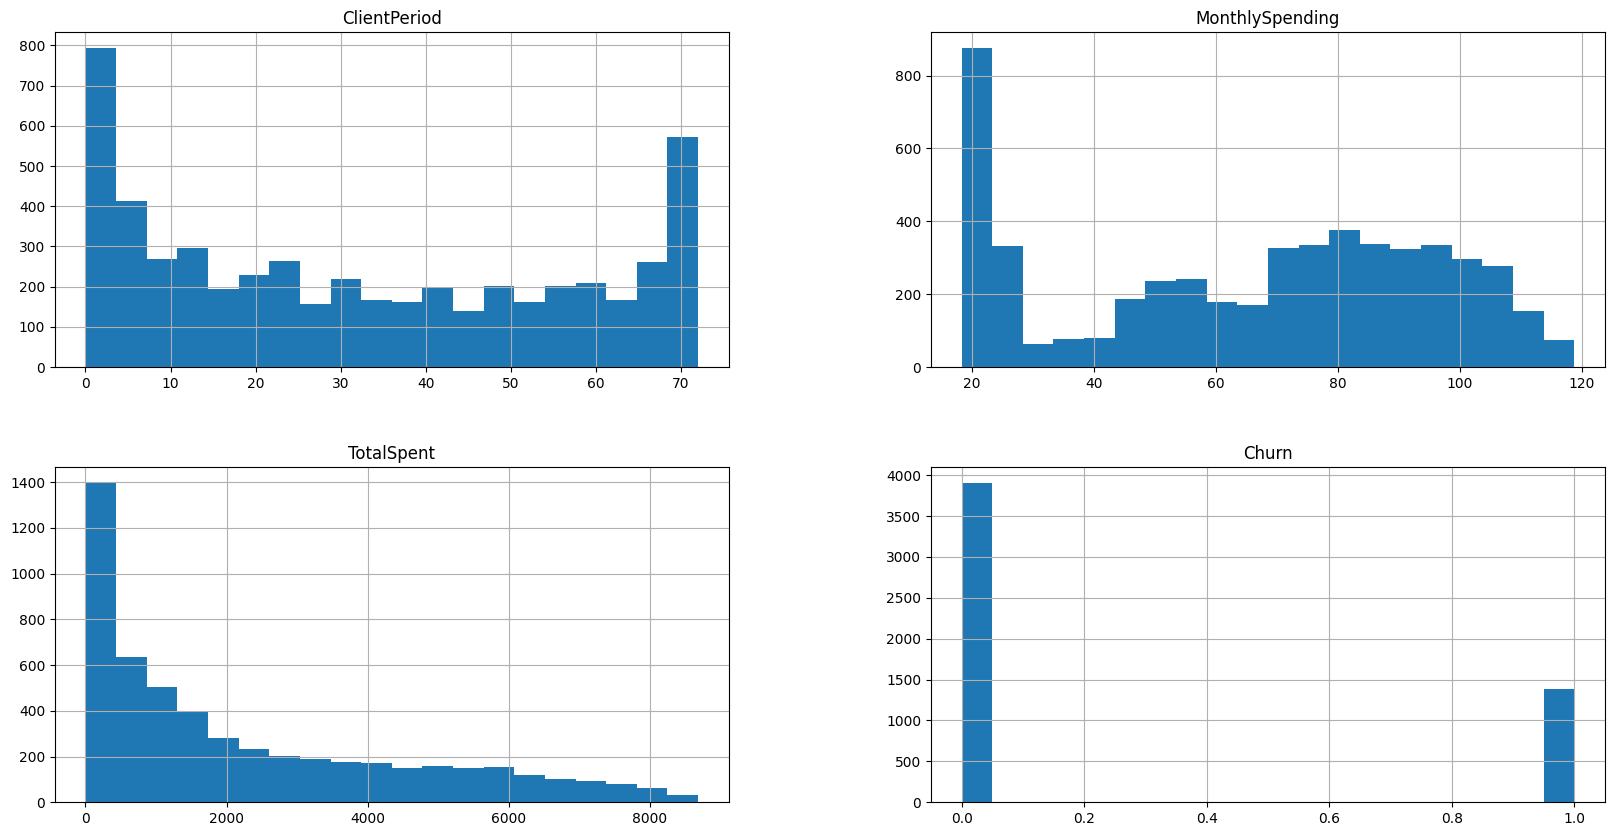

In [ ]:
#построим гистограммы для численных признаков и целевой переменной
df.hist(bins=20, figsize=(20,10));

Text(0.5, 1.0, 'TotalSpent')

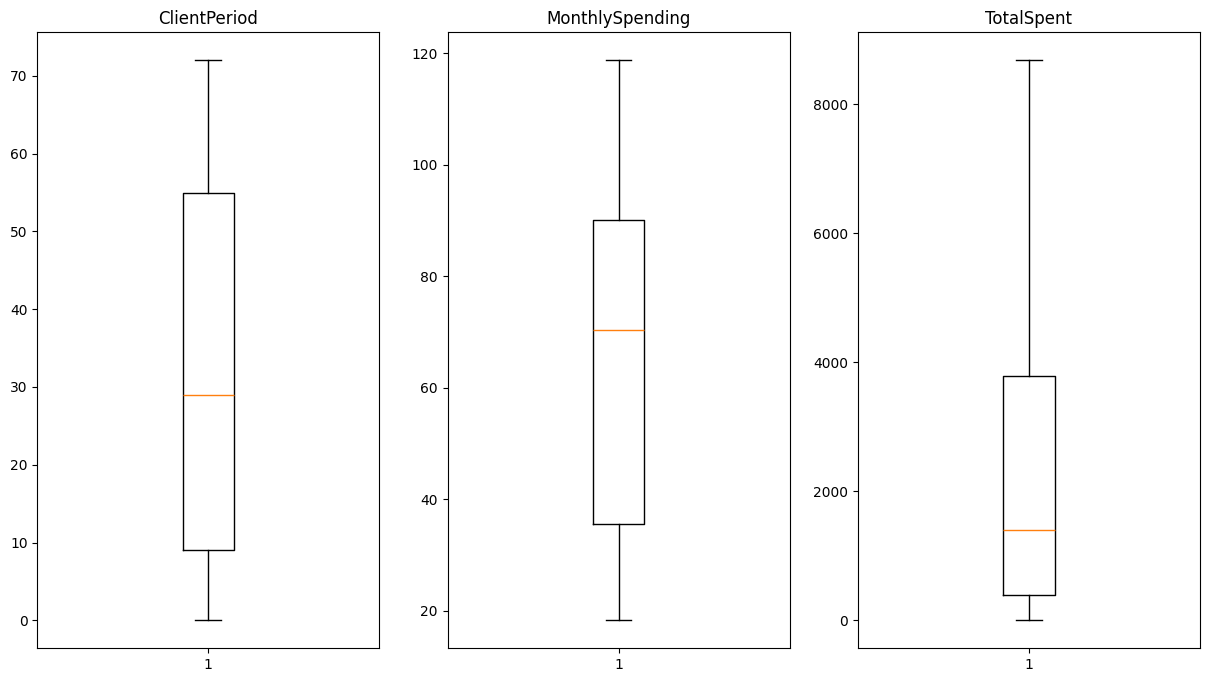

In [ ]:
#построим графики boxplot для численных признаков
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,8))
axes[0].boxplot(df['ClientPeriod'])
axes[0].set_title('ClientPeriod')

axes[1].boxplot(df['MonthlySpending'])
axes[1].set_title('MonthlySpending')

axes[2].boxplot(df['TotalSpent'])
axes[2].set_title('TotalSpent')

Медиана срока использования услуг - 30 месяцев, с затратами на услуги около 70$ в месяц.

Выбросы в данных отсутствуют

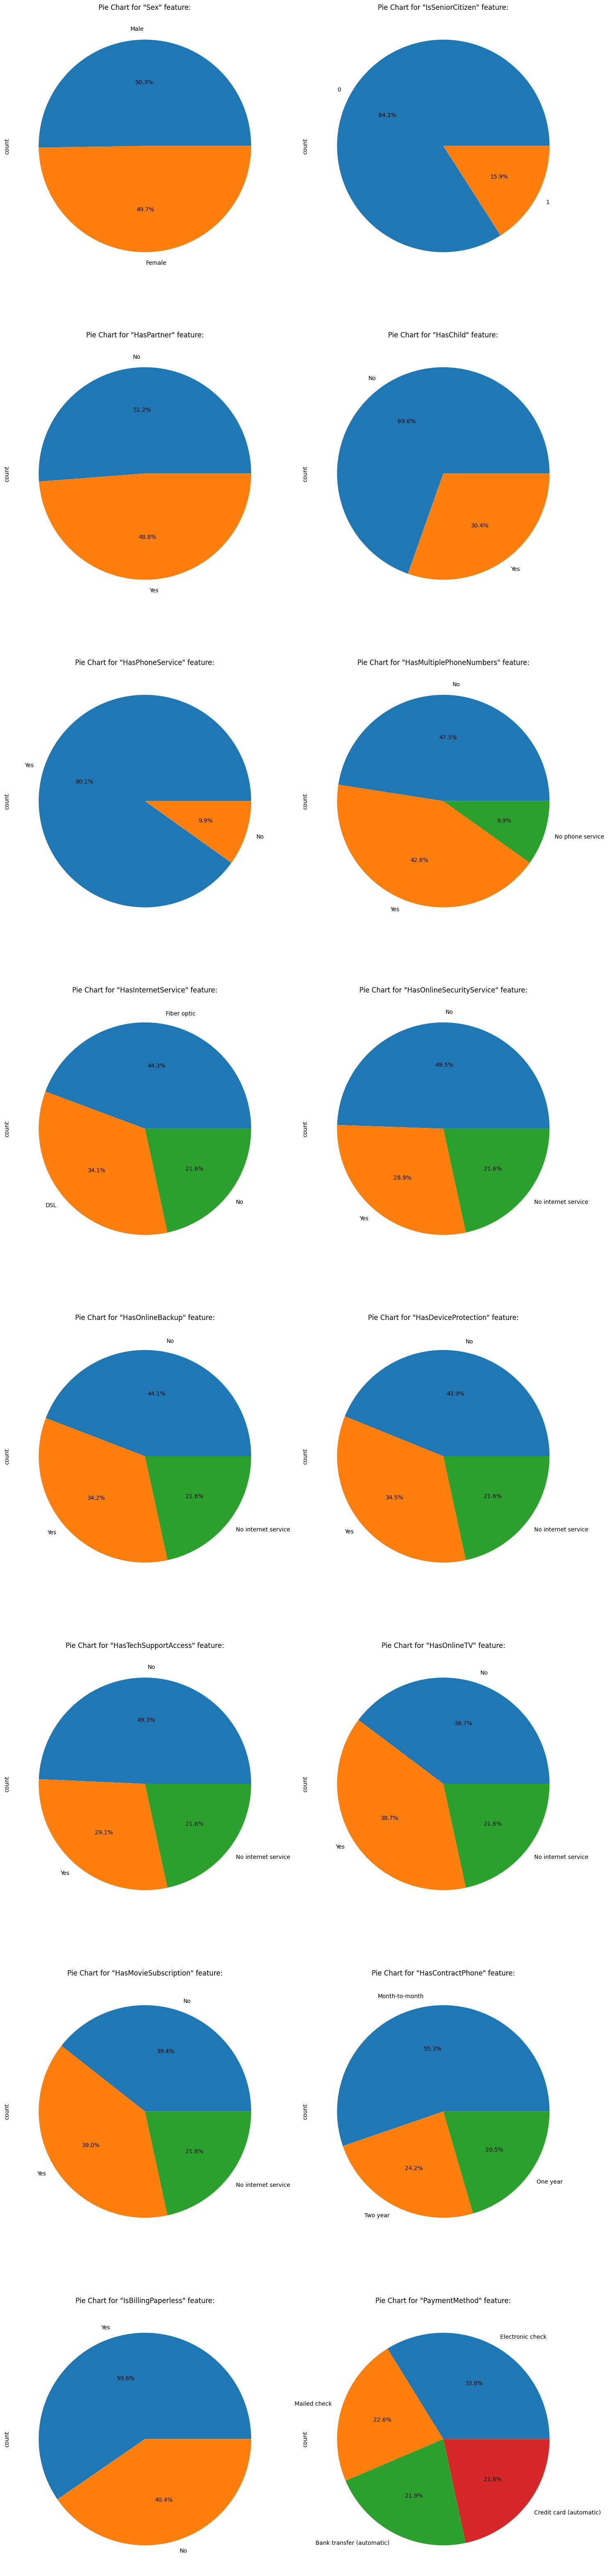

In [ ]:
#построим груговые диаграммы для категориальных признаков
num_plots = len(cat_cols)
cols = 2  # Количество столбцов в сетке
rows = (num_plots + cols - 1) // cols  # Вычисляем необходимое количество строк

fig, axes = plt.subplots(rows, cols, figsize=(15, 8 * rows))
axes = axes.flatten()  # Упрощаем доступ к подграфикам

for i, col in enumerate(cat_cols):
    df[col].value_counts().plot(grid=True, kind='pie', ax=axes[i], autopct='%1.1f%%')
    axes[i].set_title(f'Pie Chart for "{col}" feature:')

plt.tight_layout()  # Подгоняем подграфики
plt.show()

Проверим линейные корреляции числовых признаков с целевым `churn`:

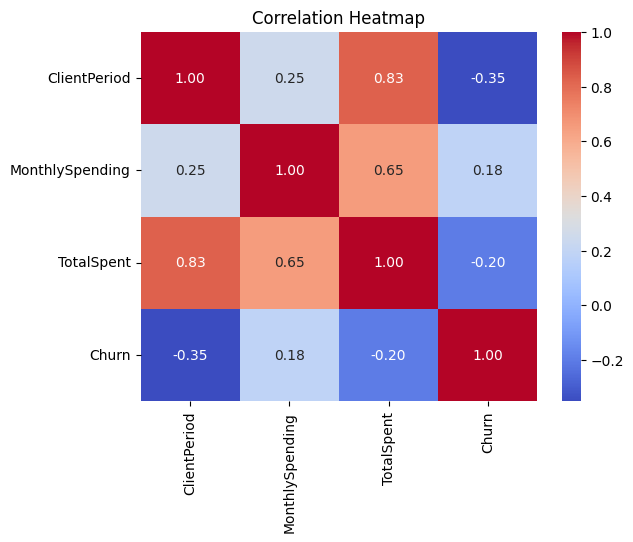

In [ ]:
sns.heatmap(df[num_cols + ['Churn']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Линейные зависимости между численными признаками и целевой переменной не наблюдаются. Однако, есть сильная корреляция между `TotalSpent` и `ClientPeriod`, что вполне логично: чем дольше клиент пользуется услугами, тем больше суммарные затраты.

Проверим нелинейные зависимости между категориальными признаками и целевым `churn`:

In [ ]:
phik_overview = df[cat_cols + ['Churn']].phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['Churn']


,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
Sex,1.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00
IsSeniorCitizen,0.00,1.00,0.01,0.33,0.00,0.08,0.16,0.12,0.11,0.11,0.13,0.11,0.11,0.09,0.23,0.29,0.24
HasPartner,0.00,0.01,1.00,0.64,0.00,0.08,0.00,0.09,0.09,0.10,0.08,0.08,0.08,0.18,0.00,0.24,0.23
HasChild,0.01,0.33,0.64,1.00,0.00,0.01,0.12,0.12,0.10,0.10,0.11,0.09,0.09,0.14,0.16,0.22,0.25
HasPhoneService,0.00,0.00,0.00,0.00,1.00,1.00,0.28,0.11,0.11,0.10,0.11,0.11,0.11,0.00,0.02,0.00,0.00
HasMultiplePhoneNumbers,0.00,0.08,0.08,0.01,1.00,1.00,0.74,0.54,0.56,0.56,0.54,0.58,0.58,0.25,0.10,0.17,0.02
HasInternetService,0.00,0.16,0.00,0.12,0.28,0.74,1.00,0.95,0.94,0.94,0.95,0.95,0.95,0.50,0.23,0.31,0.19
HasOnlineSecurityService,0.00,0.12,0.09,0.12,0.11,0.54,0.95,1.00,0.95,0.95,0.95,0.94,0.94,0.64,0.20,0.31,0.22
HasOnlineBackup,0.00,0.11,0.09,0.10,0.11,0.56,0.94,0.95,1.00,0.95,0.95,0.95,0.95,0.59,0.19,0.29,0.18
HasDeviceProtection,0.00,0.11,0.10,0.10,0.10,0.56,0.94,0.95,0.95,1.00,0.95,0.95,0.95,0.64,0.19,0.29,0.17


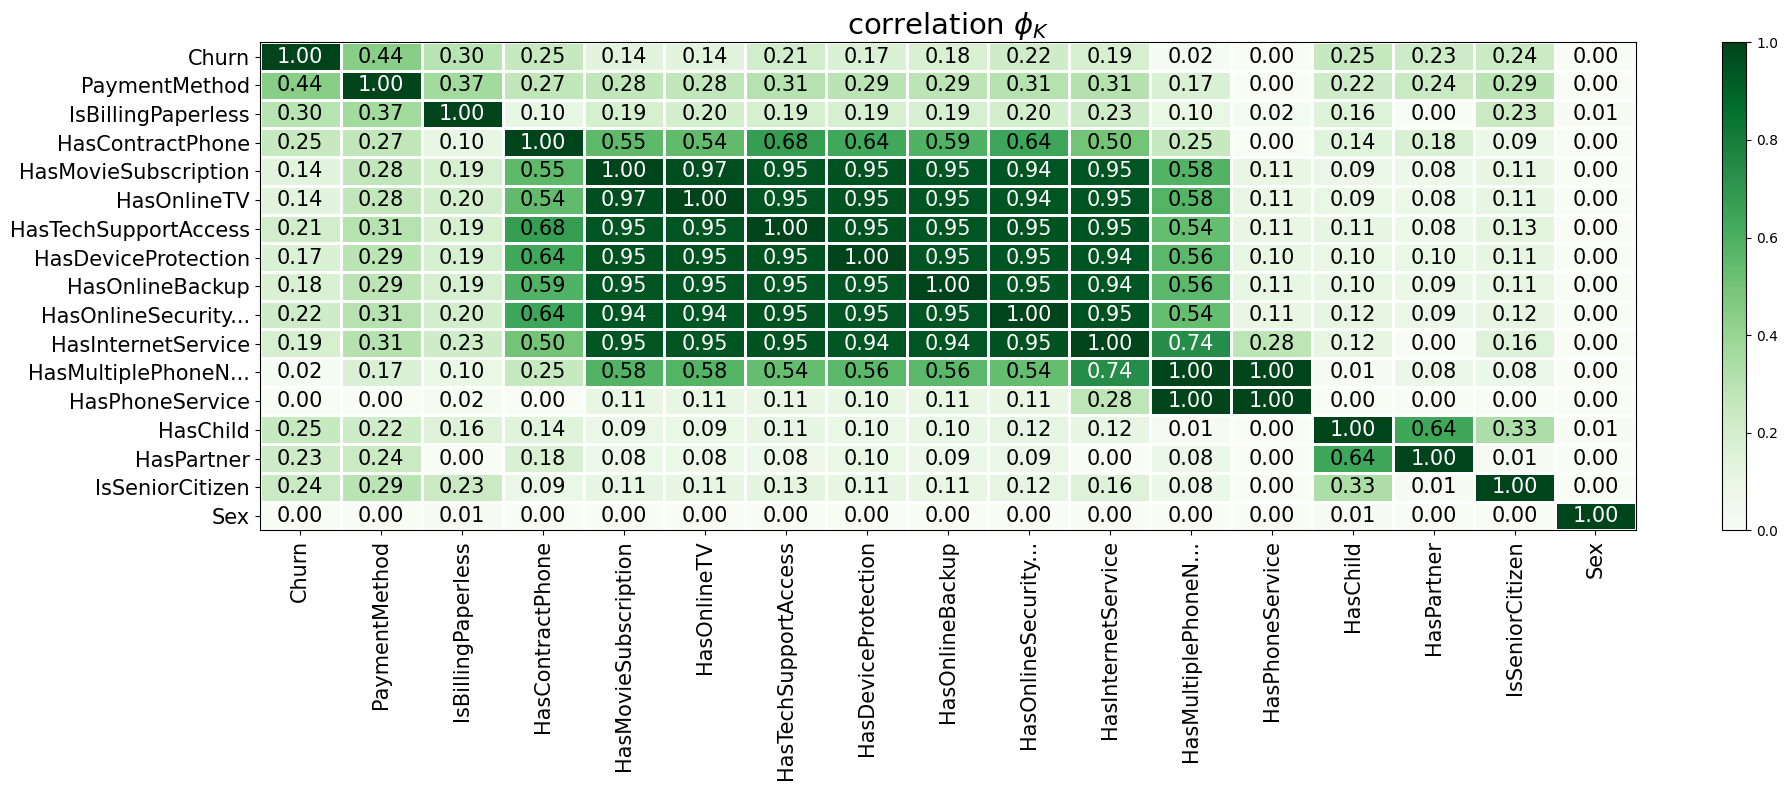

In [ ]:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1.5,
                        figsize=(20, 8))
plt.tight_layout()

Наблюдается очень сильная корреляция между признаками доп.услуг интернета (`has...`).

Также заметно влияние способа оплаты `PaymentMethod` на целевую `Churn`.

Посмотрим отдельно на распределение ушедших клиентов в зависимости от признаков, с которыми выявлена большая корреляция: `is_billing_paperless`, `has_contract_phone`, `payment_method`:

In [ ]:
pivot  = df.pivot_table(values='Churn', index='IsBillingPaperless', aggfunc='count')
pivot['доля, %'] = ((pivot ['Churn'] / pivot ['Churn'].sum())* 100).round(2)
pivot.sort_values(by='доля, %', ascending=False)

,Churn,"доля, %"
IsBillingPaperless,,
Yes,3148,59.6
No,2134,40.4


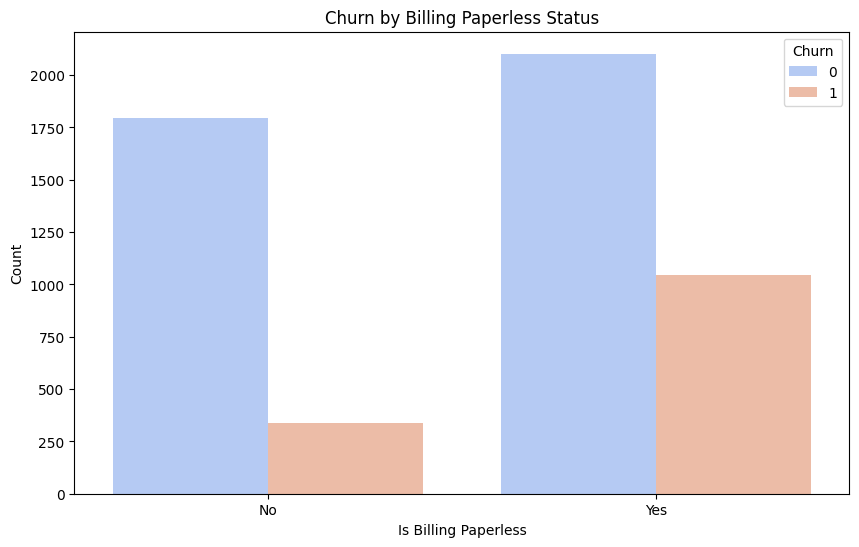

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='IsBillingPaperless', hue='Churn', palette='coolwarm')
plt.title('Churn by Billing Paperless Status')
plt.xlabel('Is Billing Paperless')
plt.ylabel('Count')
plt.legend(title='Churn', loc='upper right')
plt.show()

Чаще покидают компанию клиенты с безналичной системой оплаты

In [ ]:
pivot  = df.pivot_table(values='Churn', index='HasContractPhone', aggfunc='count')
pivot['доля, %'] = ((pivot ['Churn'] / pivot ['Churn'].sum())* 100).round(2)
pivot.sort_values(by='доля, %', ascending=False)

,Churn,"доля, %"
HasContractPhone,,
Month-to-month,2920,55.28
Two year,1280,24.23
One year,1082,20.48


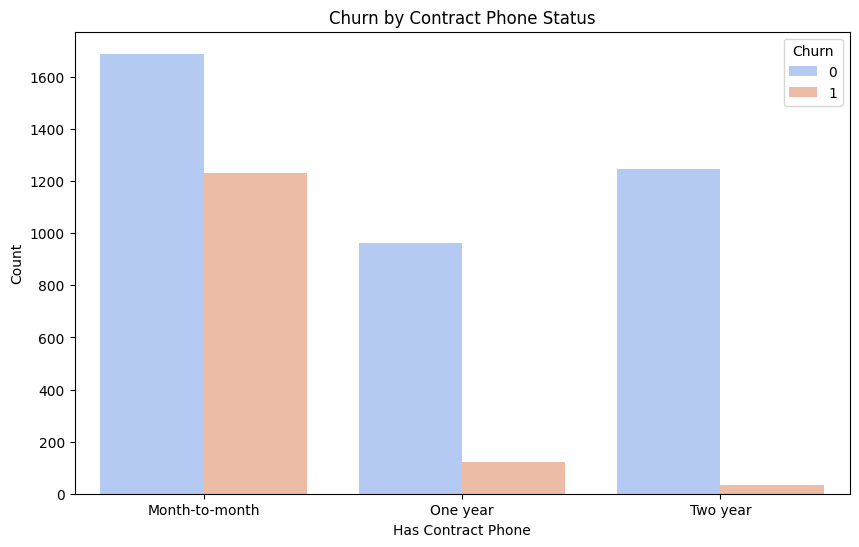

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='HasContractPhone', hue='Churn', palette='coolwarm')
plt.title('Churn by Contract Phone Status')
plt.xlabel('Has Contract Phone')
plt.ylabel('Count')
plt.legend(title='Churn', loc='upper right')
plt.show()

Большая часть оттока пользователей телефона относится к клиентам с помесячной оплатой телефона.

In [ ]:
pivot  = df.pivot_table(values='Churn', index='PaymentMethod', aggfunc='count')
pivot['доля, %'] = ((pivot ['Churn'] / pivot ['Churn'].sum())* 100).round(2)
pivot.sort_values(by='доля, %', ascending=False)

,Churn,"доля, %"
PaymentMethod,,
Electronic check,1786,33.81
Mailed check,1194,22.61
Bank transfer (automatic),1159,21.94
Credit card (automatic),1143,21.64


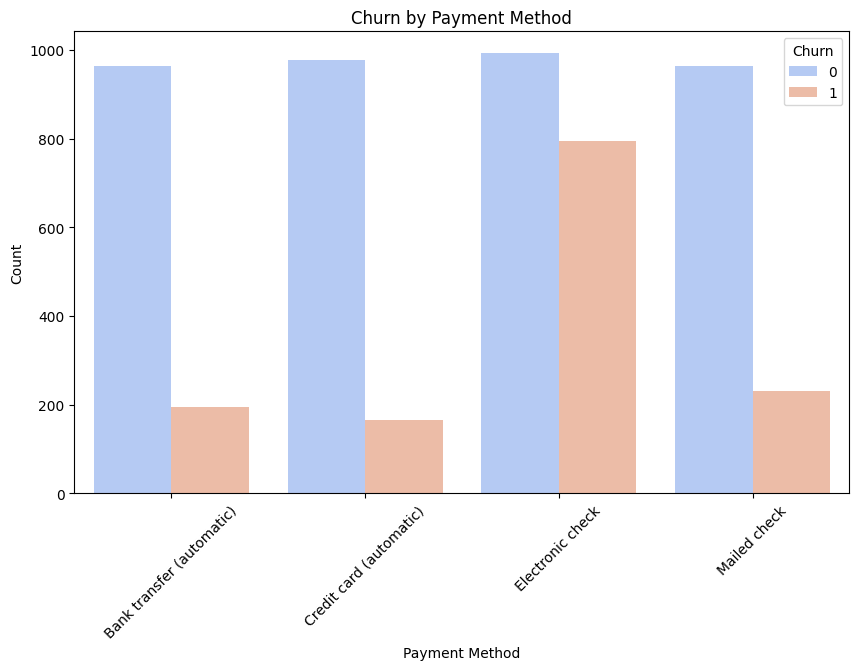

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='PaymentMethod', hue='Churn', palette='coolwarm')
plt.title('Churn by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title='Churn', loc='upper right')
plt.show()

Пользователи с типом оплаты `Electronic check` имеют наибольшую вероятность разорвать контракт.

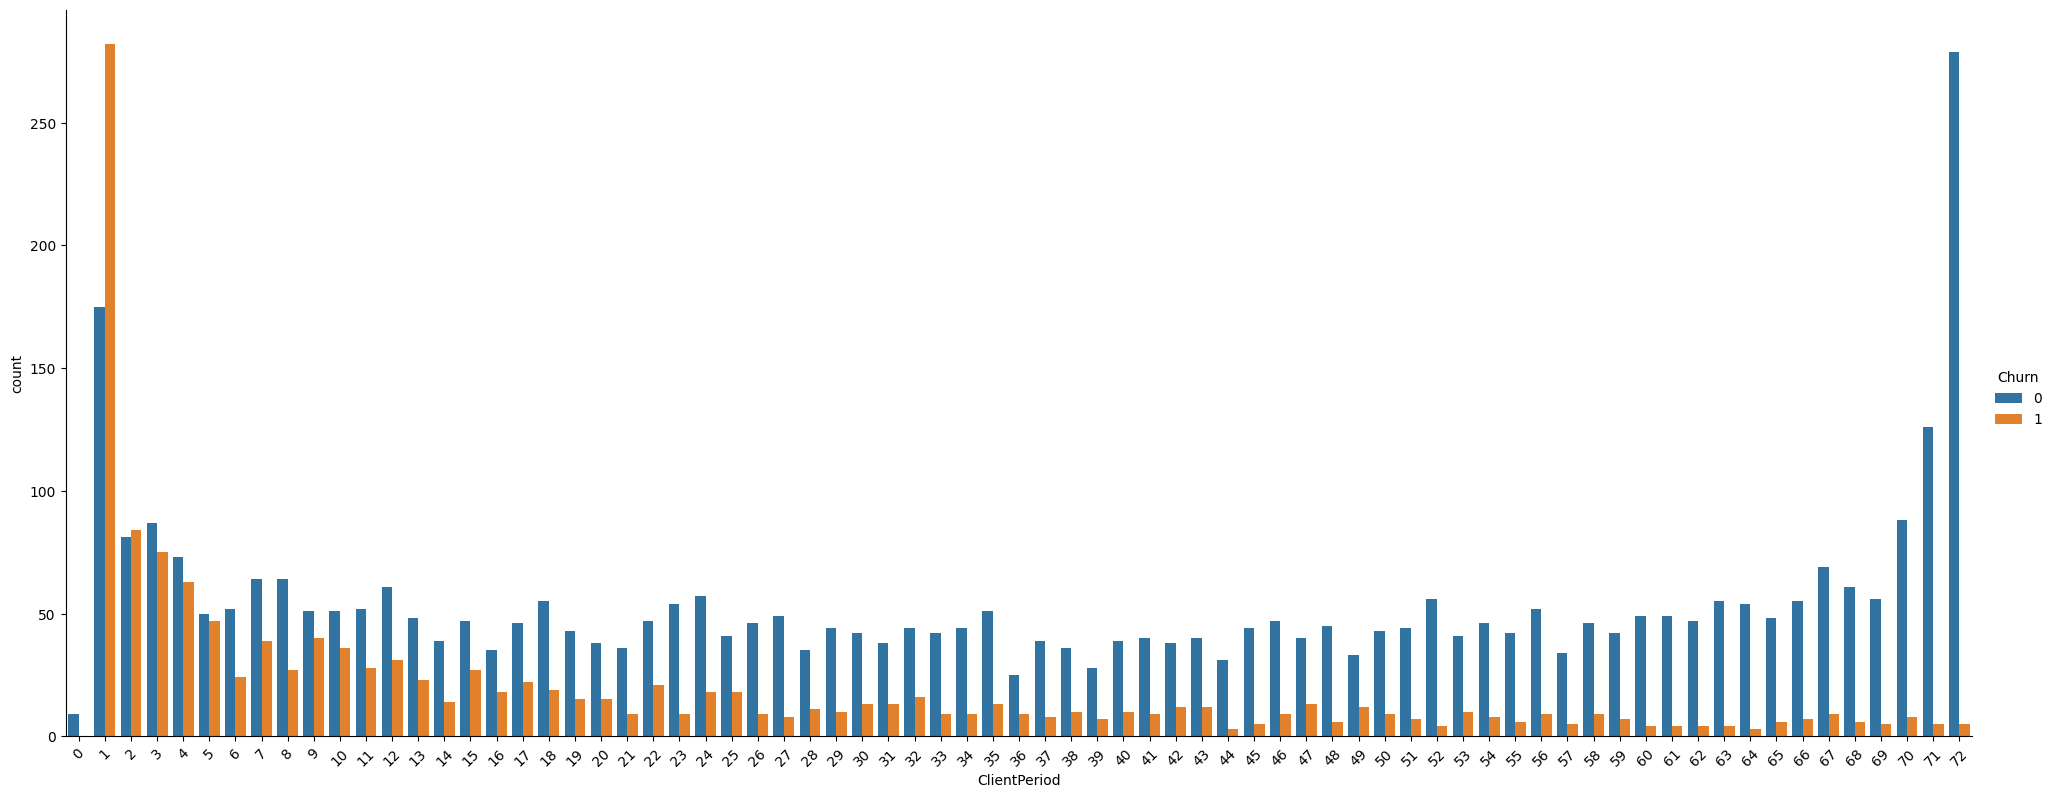

In [ ]:
sns.catplot(data=df, x='ClientPeriod', hue="Churn", kind="count", height=8, aspect=20/8)
plt.xticks(rotation=45);

Чаще всего клиенты уходят в первые 5 периодов, однако подавляющий пик - после
первого.

**Вывод:**
1. Целевая переменная `churn` несбалансированна. Отношение 1:3
2. Числовые признаки не имеют выбросов.
3. Наблюдается обратная корреляцию целевого признака `churn` с признаком `client_period`. Значит, чем больше клиент пользуется услугами, тем меньше вероятность его ухода.
4. Среди категоральных признаков сильнейшим влиянием обладают признаки `is_billing_paperless`, `PaymentMethod` и `has_contract_phone`.
5. Большая часть клиентов уходит в первые 12 месяцев (особенно - в первые 4)


# Применение моделей ML

Предварительно разделим датасет на выборки во избежание утечки данных с трейн на тест:

In [ ]:
#узнаем соотношение значений таргета
df['Churn'].value_counts().sort_values(ascending=False)

,count
Churn,
0,3898
1,1384


Учтем дисбаланс при разбиении на выборки:

In [ ]:
target = df['Churn'] #целевая переменная
original_features = df.drop('Churn', axis=1) #матрица признаков

In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(
    original_features, target, test_size=0.2, stratify=target, random_state=282)

In [ ]:
results = [] #словарь для результатов
models = []

Подготовим шаблон пайплайна для предобработки категориальных и числовых признаков:

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_cols)
    ]
)

## Константная модель

Большая часть значений в таргете - 0. Заполним этим значением вектор предсказаний и вычислим метрику `roc_auc_score`.

In [ ]:
valid_constant = pd.Series(data=0, index=target_valid.index)

#Мы не можем измерить метрику для констатной модели, т.к. при констатномпредсказани у нас будет только один класс
#с этой целью присвоим одному из значений "1"
valid_constant[0] = 1
roc_auc_constant = roc_auc_score(valid_constant, target_valid)
results.append(roc_auc_constant)
models.append('Constant model')
models
roc_auc_constant

0.36884469696969696

Мы не можем измерить метрику для констатной модели, т.к. при констатномпредсказани у нас будет только один класс. Ни f1_score, ни roc_auc не выдадут результата.

## Baseline модель

В качестве бейслайн решения возьмем логистическую регрессию. Чтобы измерять метрику roc_auc сразу на k-фолдах, подготовить данные в подходящий формат, а также уберечь их от утечки, буде миспользовать pipeline + Gridsearch для подбора гиперпараметров

In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('modelling', LogisticRegression(random_state=282))
])

parameters = {'modelling__C': [100, 10, 1, 0.1, 0.01, 0.001],
              'modelling__penalty': ['l1','l2'],
              'modelling__solver': ['liblinear', 'lbfgs','saga']
             }

clf = GridSearchCV(pipeline,
                   parameters,
                   scoring='roc_auc',
                   cv=5,
                   verbose=0,
                   n_jobs= -1)
clf.fit(features_train, target_train)

linear_model = clf.best_estimator_
valid_predictions = linear_model.predict_proba(features_valid)[:, 1]

valid_roc_auc = roc_auc_score(target_valid, valid_predictions)
results.append(valid_roc_auc)
models.append('Logistic Regression')

print(f'ROC AUC on validation set: {valid_roc_auc}')
print()
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()


ROC AUC on validation set: 0.8197098028325465

Best parameters set found on development set:

{'modelling__C': 1, 'modelling__penalty': 'l1', 'modelling__solver': 'saga'}



## RandomForestClassifier

Попробуем ансамблевую модель RandomForest с подбором гиперпараметров через средства scikit-learn,а именно - чере GrisSrarch с встроенным инструментом кросс-вализаци (параметр `cv=5`)

In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('modelling', RandomForestClassifier())
])

parameters = {'modelling__n_estimators': [15, 50, 100, 200],
              'modelling__criterion': ['entropy', 'gini'],
              'modelling__max_depth': [3, 6, 9, 12, 15]
             }

clf = GridSearchCV(pipeline,
                   parameters,
                   scoring='roc_auc',
                   cv=5,
                   verbose=1,
                   n_jobs=-1)

clf.fit(features_train, target_train)

best_model_tree = clf.best_estimator_
valid_predictions = best_model_tree.predict_proba(features_valid)[:, 1]

valid_roc_auc = roc_auc_score(target_valid, valid_predictions)
results.append(valid_roc_auc)
models.append('Random Forest')

print(f'ROC AUC on validation set: {valid_roc_auc}')
print()
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()


Fitting 5 folds for each of 40 candidates, totalling 200 fits
ROC AUC on validation set: 0.821160788669814

Best parameters set found on development set:

{'modelling__criterion': 'entropy', 'modelling__max_depth': 6, 'modelling__n_estimators': 200}



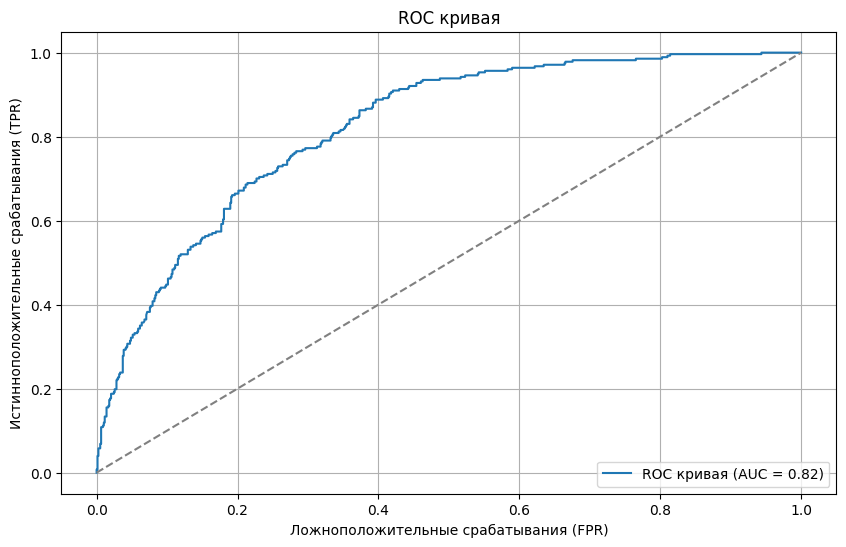

In [ ]:
fpr, tpr, thresholds = roc_curve(target_valid, valid_predictions)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC кривая (AUC = {valid_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Линия случайного предсказания
plt.xlabel('Ложноположительные срабатывания (FPR)')
plt.ylabel('Истинноположительные срабатывания (TPR)')
plt.title('ROC кривая')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Градиентный бустинг Catboost

Произведем подбор гиперпараметров с библиотекой optuna на ансамблевой модели на градиентном бустинге.

In [ ]:
import optuna
import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# Подготовка данных
# Кодируем категориальные переменные с помощью LabelEncoder (или OneHotEncoder, если необходимо)
from sklearn.preprocessing import LabelEncoder

# Кодируем категориальные признаки
for col in cat_cols:
    le = LabelEncoder()
    features_train[col] = le.fit_transform(features_train[col])
    features_valid[col] = le.transform(features_valid[col])

X = features_train  # Признаки для обучения
y = target_train  # Целевая переменная

# Функция для оптимизации с помощью Optuna
def objective(trial):
    # Определяем гиперпараметры для подбора
    params = { #отбираем ключевые параметры для бустинга на деревьях
        'n_estimators': trial.suggest_int('n_estimators', 100, 300, step=100), #количество деревьев
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1), #скорость обучения=шаг градиента
        'max_depth': trial.suggest_int('max_depth', 3, 12, step=3), #
        'eval_metric': 'auc',
        'objective': 'binary:logistic',  # Для бинарной классификации
        'random_state': 282
    }

    # Создаем модель с выбранными параметрами
    model = xgb.XGBClassifier(**params)

    # Используем кросс-валидацию для оценки AUC
    auc_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

    # Возвращаем среднее значение AUC
    return np.mean(auc_scores)

# Оптимизация гиперпараметров с помощью Optuna
study = optuna.create_study(direction='maximize')  # Студия для максимизации AUC
study.optimize(objective, n_trials=10)  # Запуск оптимизации

# Печать лучших гиперпараметров
print(f"Best hyperparameters: {study.best_params}")

# Обучение модели с лучшими гиперпараметрами
best_params = study.best_params
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X, y)

# Предсказания для валидации
valid_predictions = best_model.predict_proba(features_valid)[:, 1]
valid_roc_auc = roc_auc_score(target_valid, valid_predictions)
results.append(valid_roc_auc)
models.append('XGBoost')
print(f"Validation ROC AUC: {valid_roc_auc:.4f}")


[I 2024-12-03 13:36:14,528] A new study created in memory with name: no-name-ea355a60-189f-4c4f-a775-e3c457cf9c0d
[I 2024-12-03 13:36:15,070] Trial 0 finished with value: 0.8497094149348332 and parameters: {'n_estimators': 100, 'learning_rate': 0.08023492920977669, 'max_depth': 3}. Best is trial 0 with value: 0.8497094149348332.
[I 2024-12-03 13:36:19,220] Trial 1 finished with value: 0.843394826920934 and parameters: {'n_estimators': 300, 'learning_rate': 0.0070134072945624, 'max_depth': 6}. Best is trial 0 with value: 0.8497094149348332.
[I 2024-12-03 13:36:31,041] Trial 2 finished with value: 0.8234834177275328 and parameters: {'n_estimators': 300, 'learning_rate': 0.006669591946197832, 'max_depth': 12}. Best is trial 0 with value: 0.8497094149348332.
[I 2024-12-03 13:36:37,142] Trial 3 finished with value: 0.8292058144007912 and parameters: {'n_estimators': 200, 'learning_rate': 0.05446496168101666, 'max_depth': 9}. Best is trial 0 with value: 0.8497094149348332.
[I 2024-12-03 13:3

Best hyperparameters: {'n_estimators': 100, 'learning_rate': 0.08023492920977669, 'max_depth': 3}
Validation ROC AUC: 0.8246


## Сравнительная таблица:

In [ ]:
table = pd.DataFrame(data=
                     {'Models': models,
                     'ROC_AUC': results},
                    )
table.sort_values(by='ROC_AUC', ascending=False)


,Models,ROC_AUC
3,XGBoost,0.824602
2,Random Forest,0.821161
1,Logistic Regression,0.819710
0,Constant model,0.368845


**Вывод:** Модели показали в целом схожий результат. Проверим RandomForest на тестовой выборке:

# Предсказания

## Предсказание на лучшей модели:

In [ ]:
best_model_tree.fit(original_features, target)
test_predictions = best_model_tree.predict_proba(test)[:, 1]

In [ ]:
submission = pd.DataFrame({
    'Id': range(len(test)),
    'Churn': test_predictions
})
submission.to_csv('submission.csv', index=False)

Результат на kaggle https://www.kaggle.com/competitions/advanced-dls-spring-2021 (Evgenii Fomin):

ROC-AUC: 0.8475

# Интерпретация модели

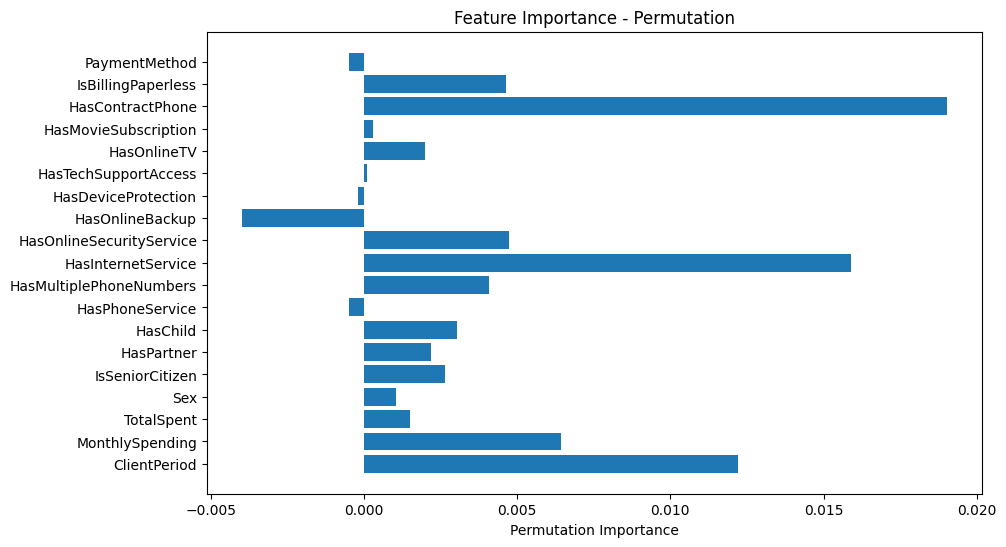

In [ ]:
best_model_tree.fit(features_train, target_train)
result = permutation_importance(best_model_tree,
                                features_valid,
                                target_valid,
                                n_repeats=10,
                                random_state=282,
                                n_jobs=-1)
importance = result.importances_mean
feature_names = features_train.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importance)  # Преобразуем feature_names в массив
plt.xlabel('Permutation Importance')
plt.title('Feature Importance - Permutation')
plt.show()

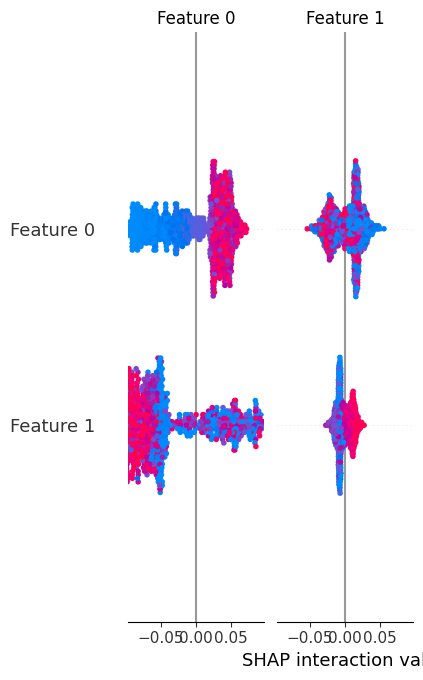

In [ ]:
# 2. SHAP summary plot
features_valid_transformed = best_model_tree.steps[0][1].transform(features_valid)

explainer = shap.TreeExplainer(best_model_tree.steps[1][1])
shap_values = explainer.shap_values(features_valid_transformed)

shap.summary_plot(shap_values, features_valid_transformed, plot_size=(10, 8))

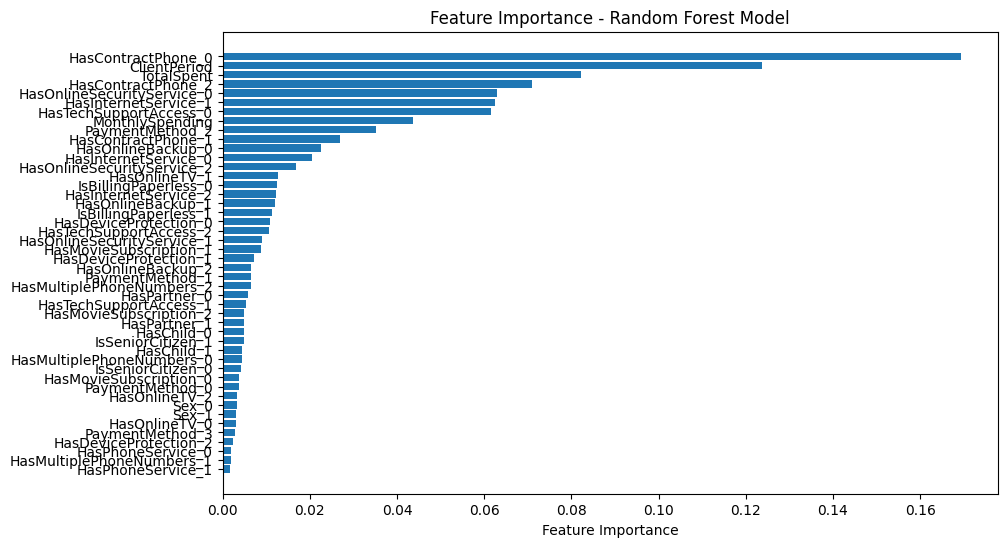

In [ ]:
importances = best_model_tree.steps[1][1].feature_importances_

# Получаем индексы признаков по убыванию важности
sorted_idx = importances.argsort()
sorted_importances = importances[sorted_idx]

num_feature_names = np.array(num_cols)
cat_feature_names = best_model_tree.steps[0][1].transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_cols) #получаем имена для one-hot кодированных признаков

# Объединяем имена всех признаков
feature_names = np.concatenate([num_feature_names, cat_feature_names])

# Теперь сортируем имена признаков по важности
sorted_feature_names = feature_names[sorted_idx]

plt.figure(figsize=(16, 10))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Random Forest Model')
plt.show()

**Вывод**:

1. Выполнен исследовательский анализ данных, предобработка признаков, обзор числовых и категориальных данных на предмет зависимости с целевой переменной.
2. Интерпретация зависимости показателей моделей от признаков показывает едина с результатами EDA: наличие подключенного телефона с ежемесячной оплатой сильнее всех влияет на отток клиентов в положительную сторону. ПОчти половина таких пользователей покидает компанию. Разрывают контракт с оператором связи чаще всего в течении 4 месяцев.